<img src="tmva_logo.gif" height="20%" width="20%">

# TMVA Classification Example Using a Convolutional Neural Network

## Declare Factory

Create the Factory class. Later you can choose the methods
whose performance you'd like to investigate. 

The factory is the major TMVA object you have to interact with. Here is the list of parameters you need to pass

 - The first argument is the base of the name of all the output
weightfiles in the directory weight/ that will be created with the 
method parameters 

 - The second argument is the output file for the training results
  
 - The third argument is a string option defining some general configuration for the TMVA session. For example all TMVA output can be suppressed by removing the "!" (not) in front of the "Silent" argument in the option string

In [1]:
import ROOT
from ROOT import TMVA
import os 


Welcome to JupyROOT 6.15/01


In [2]:
ROOT.TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

## For PYMVA methods
TMVA.PyMethodBase.PyInitialize();


outputFile = ROOT.TFile.Open("CNN_ClassificationOutput.root", "RECREATE")

factory = ROOT.TMVA.Factory("TMVA_CNN_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input variables 

Define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In this case the input data consists of an image of 16x16 pixels. Each single pixel is a branch in a ROOT TTree

In [3]:
inputFileName = "images_data.root"

inputFile = ROOT.TFile.Open( inputFileName )

# retrieve input trees

signalTree     = inputFile.Get("sig_tree")
backgroundTree = inputFile.Get("bkg_tree")

signalTree.Print()

******************************************************************************
*Tree    :sig_tree  : signal_tree                                            *
*Entries :    10000 : Total =         2601382 bytes  File  Size =    2572423 *
*        :          : Tree compression factor =   1.00                       *
******************************************************************************
*Br    0 :var0      : var0/F                                                 *
*Entries :    10000 : Total  Size=      40631 bytes  File Size  =      40150 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.00     *
*............................................................................*
*Br    1 :var1      : var1/F                                                 *
*Entries :    10000 : Total  Size=      40631 bytes  File Size  =      40150 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.00     *
*...................................................

In [4]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signalTree,     signalWeight     )
loader.AddBackgroundTree( backgroundTree, backgroundWeight )

imgSize = 8 * 8; 
for  i in range(0,imgSize):
    varName = "var"+str(i)
    loader.AddVariable(varName,'F');


DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 10000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 10000 events


## Setup Dataset(s)

Define input data file and signal and background trees

In [5]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


loader.PrepareTrainingAndTestTree( mycuts, mycutb,
                                  "nTrain_Signal=5000:nTrain_Background=5000:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

# Booking Methods

Here we book the TMVA methods. We book a DNN and a CNN

#### Booking Deep Neural Network

Here we book the new DNN of TMVA. If using master version you can use the new DL method

In [6]:
inputLayoutString = "InputLayout=1|1|64"; 
batchLayoutString= "BatchLayout=1|32|64";
layoutString = ("Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR")

training1  = "Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=None,WeightDecay=1e-4,"
training1 += "DropConfig=0.+0.+0.+0.,MaxEpochs=30,ConvergenceSteps=10,BatchSize=32,TestRepetitions=1"
trainingStrategyString = "TrainingStrategy=" + training1


dnnOptions = "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER::Architecture=CPU"

dnnOptions +=  ":" + inputLayoutString
dnnOptions +=  ":" + batchLayoutString
dnnOptions +=  ":" + layoutString
dnnOptions +=  ":" + trainingStrategyString

#we can now book the method
              
factory.BookMethod(loader, ROOT.TMVA.Types.kDL, "DL_DENSE", dnnOptions)


<ROOT.TMVA::MethodDL object ("DL_DENSE") at 0x252cc50>

Factory                  : Booking method: DL_DENSE
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER::Architecture=CPU:InputLayout=1|1|64:BatchLayout=1|32|64:Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=None,WeightDecay=1e-4,DropConfig=0.+0.+0.+0.,MaxEpochs=30,ConvergenceSteps=10,BatchSize=32,TestRepetitions=1"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER::Architecture=C

### Book Convolutional Neural Network in TMVA

In [7]:
#input layout 
inputLayoutString = "InputLayout=1|8|8"
                                                                                                
## Batch Layout                                                                                                                                     
batchLayoutString = "BatchLayout=128|1|64"
                                                   

layoutString = ("Layout=CONV|10|3|3|1|1|1|1|RELU,CONV|10|3|3|1|1|1|1|RELU,MAXPOOL|2|2|1|1,"
            "RESHAPE|FLAT,DENSE|64|TANH,DENSE|1|LINEAR")
                                                                                                                                              


##Training strategies.                                                                                                                          
training1 = ("LearningRate=1e-3,Momentum=0.9,Repetitions=1,"
                     "ConvergenceSteps=10,BatchSize=128,TestRepetitions=1,"
                     "MaxEpochs=20,WeightDecay=1e-4,Regularization=None,"
                     "Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.0")
 
trainingStrategyString = "TrainingStrategy=" + training1
    
## General Options.                                                                                                                              
cnnOptions = ("!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"
                       "WeightInitialization=XAVIERUNIFORM");

cnnOptions +=  ":" + inputLayoutString
cnnOptions +=  ":" + batchLayoutString
cnnOptions +=  ":" + layoutString
cnnOptions +=  ":" + trainingStrategyString
cnnOptions +=  ":Architecture=CPU"

##book CNN
factory.BookMethod(loader, ROOT.TMVA.Types.kDL, "DL_CNN", cnnOptions);


Factory                  : Booking method: DL_CNN
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIERUNIFORM:InputLayout=1|8|8:BatchLayout=128|1|64:Layout=CONV|10|3|3|1|1|1|1|RELU,CONV|10|3|3|1|1|1|1|RELU,MAXPOOL|2|2|1|1,RESHAPE|FLAT,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,Repetitions=1,ConvergenceSteps=10,BatchSize=128,TestRepetitions=1,MaxEpochs=20,WeightDecay=1e-4,Regularization=None,Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.0:Architecture=CPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSEN

### Book Convolutional Neural Network in Keras using a generated model 

In [8]:
## to use tensorflow backend
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [9]:
from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [10]:
model = Sequential()
model.add(Reshape((8,8, 1), input_shape=(64,)))
model.add(Conv2D(10, kernel_size=(3,3), kernel_initializer='TruncatedNormal', activation='relu', padding='same' ) )
model.add(Conv2D(10, kernel_size=(3,3), kernel_initializer='TruncatedNormal', activation='relu', padding='same' ) )
#stride for maxpool is equal to pool size
model.add(MaxPooling2D(pool_size=(2, 2) ))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.save('model_cnn.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 8, 8, 1)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 10)          100       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 10)          910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                10304     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total para

2018-10-20 16:28:47.791863: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [11]:

factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, 
                       "PyKeras","H:!V:VarTransform=None:FilenameModel=model_cnn.h5:"
                       "FilenameTrainedModel=trained_model_cnn.h5:NumEpochs=20:BatchSize=128");


Factory                  : Booking method: PyKeras
                         : 
                         : Load model from file: model_cnn.h5


## Train Methods

In [12]:
factory.TrainAllMethods();

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 2s 198us/step - loss: 0.6803 - acc: 0.5723 - val_loss: 0.6358 - val_acc: 0.6528

Epoch 00001: val_loss improved from inf to 0.63580, saving model to trained_model_cnn.h5
Epoch 2/20
10000/10000 [==============================] - 2s 178us/step - loss: 0.5900 - acc: 0.6876 - val_loss: 0.5714 - val_acc: 0.7026

Epoch 00002: val_loss improved from 0.63580 to 0.57143, saving model to trained_model_cnn.h5
Epoch 3/20
10000/10000 [==============================] - 2s 176us/step - loss: 0.5447 - acc: 0.7246 - val_loss: 0.5413 - val_acc: 0.7240

Epoch 00003: val_loss improved from 0.57143 to 0.54130, saving model to trained_model_cnn.h5
Epoch 4/20
10000/10000 [==============================] - 2s 175us/step - loss: 0.5290 - acc: 0.7385 - val_loss: 0.5517 - val_acc: 0.7155

Epoch 00004: val_loss did not improve from 0.54130
Epoch 5/20
10000/10000 [==============================] - 2s 176us/s

## Test and Evaluate Methods

In [13]:
factory.TestAllMethods();

Factory                  : Test all methods
Factory                  : Test method: DL_DENSE for Classification performance
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
TFHandler_DL_DENSE       : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var0: -0.0095330    0.98960   [    -3.1011     5.7307 ]
                         :     var1:  0.0051908    0.98827   [    -3.0819     5.7307 ]
                         :     var2:  -0.012209     1.0051   [    -2.9940     5.7307 ]
                         :     var3: -0.0077444     1.0017   [    -2.9487     5.7307 ]
                         :     var4:   0.032363     1.0029   [    -3.0402     5.7307 ]
                         :     var5:   0.017022     1.0003   [    -2.9642     5.7307 ]
                         :    

In [14]:
factory.EvaluateAllMethods();    

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: DL_DENSE
                         : 
DL_DENSE                 : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
TFHandler_DL_DENSE       : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var0:  0.0057930    0.99712   [    -3.1847     5.7307 ]
                         :     var1:  0.0058083    0.99728   [    -3.1847     5.7307 ]
                         :     var2:  0.0059004    0.99725   [    -3.1847     5.7307 ]
                         :     var3:  0.0058396    0.99696   [    -3.1847     5.7307 ]
                         :     var4:  0.0059544    0.99700   [    -3.1847     5.7307 ]

## Plot ROC Curve
We enable JavaScript visualisation for the plots

In [ ]:
//%jsroot on

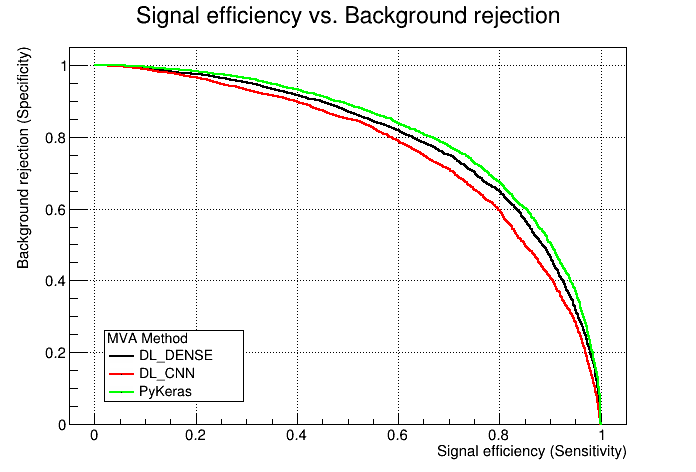

In [16]:
c1 = factory.GetROCCurve(loader)
c1.Draw()


In [18]:
## close outputfile to save output file
outputFile.Close()